# ANDM analyses

In [1]:
# load all necessary packages
%load_ext rpy2.ipython
%R library(lme4)
%R library(sjPlot)
%R library(ggplot2)

#%load_ext pymatbridge
from __future__ import division
from __future__ import print_function
from scipy.stats import norm
from scipy.signal import fftconvolve
import matplotlib.gridspec as gridspec
import brewer2mpl as b2mpl
import os, glob, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nilearn
from nilearn import image
from nilearn import plotting
import multiprocessing  
from joblib import Parallel, delayed
import pickle

eps = 2 ** -52

# a few global variables that speed up optimization
T = None
It = None
STIM_STRENGTH = None
Ic = None

sns.set_style('ticks')
sns.set_context('talk')

/Users/akram/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Need help? Try the ggplot2 mailing list:
http://groups.google.com/group/ggplot2.

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def fitData(
        data, dt=.0005, k=5, B0=1.5, Bdel=1, B2=1,
        tnd=0.5, tnd_sd=0.05, stim_strength_bias=0, y0=0, plaw=1):

    """
    Fit choices and reaction times to a diffusion to bound model
    with exponentially and symmetrically decreasing bounds

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is number of trials
          and the columns correspond to stim_strength, rt, and choice

    dt : temporal resolution of the simulated diffusion process

    ########## The following are initial values of parameters ##############

    k : float, proportionality constant between stim_strength and drift rate

    B0 : float, initial bound height

    Bdelay : float, delay in seconds before bound starts decreasing

    B2 : float, coefficient of exponential term that governs bound decrease

    tnd: float, non decision time

    tnd_sd: float, standard deviation of non-decision time

    stim_strength_bias : bias in drift rate (added to stim_strength before k mult)

    y0 : initial offset of decision variable (relative to 0)
    
    plaw : power law coefficient for stim_strengths


    Returns
    -------
    theta : 1D array of 9 params -
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    """

    global T, It, STIM_STRENGTH, Ic
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    stim_strengths = data[:, 0]
    rt = data[:, 1]
    ci = data[:, 2]

    # plausible bounds for the parameters
    theta_lo = np.array([0.2, 0.5,  0,  0, 0.3 , 1/1000000 ,-0.2,  0, 1/20])
    #theta_lo = [0.2, 0.5,  0,  0, 0.3 , 1/1000000 ,-0.2,  0, 1/20]
    theta_hi = np.array([35,  4,    5,  3, 1   , 0.1  ,0.2, 0, 3])
    #theta_hi = [35,  4,    5,  3, 1   , 0.1  ,0.2, 0, 3]
    bounds=np.c_[theta_lo, theta_hi]
    theta_init = np.array([k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw])
    #theta_init = [k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw]

    #theta, fopt = fminbnd.fminbnd(
    #    calculateNegLL, theta_init, args=(stim_strengths, rt, ci, dt),
    #    LB=theta_lo, UB=theta_hi)
    #theta=scipy.optimize.minimize(calculateNegLL, theta_init, args=(stim_strengths, rt, ci),bounds=bounds,method='L-BFGS-B',options={'disp': True})
    theta=scipy.optimize.minimize(calculateNegLL, theta_init, args=(stim_strengths, rt, ci),method='Nelder-Mead',options={'disp': True})
    # clear the globals
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    return theta
    #return theta, fopt

In [3]:
def plotDotsDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    # calculate participant means per subject
    smean = df.groupby(['subj','stim_strength'],as_index=False).mean()
    # SEM across participant means
    semprop = smean.groupby('stim_strength').sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    #means per participant per stim_strenght
    scbmeans=cb.groupby(['subj','stim_strength'],as_index=False).mean()
    scymeans=cy.groupby(['subj','stim_strength'],as_index=False).mean()
    bothmeans=df.groupby(['subj','stim_strength'],as_index=False).mean()
    del scymeans['ci'] 
    del scbmeans['ci'] 
    del bothmeans['ci']     
    
    meanrt_lo=cy.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_both=df.groupby(['stim_strength'],as_index=False).mean()['rt']
    
    semrt_lo=scymeans.groupby('stim_strength').sem()['rt']
    semrt_up=scbmeans.groupby('stim_strength').sem()['rt']
    semrt_both=df.groupby('stim_strength').sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [4]:
def plotDotsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci'])
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    # calculate stdev per stim strengh
    semprop = df.groupby(['stim_strength']).sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    meanrt_lo=cy.groupby(['stim_strength']).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength']).mean()['rt']
    meanrt_both=df.groupby(['stim_strength']).mean()['rt']
    
    del cb['ci']
    del cy['ci']
    
    semrt_lo=cy.groupby(['stim_strength']).sem()['rt']
    semrt_up=cb.groupby(['stim_strength']).sem()['rt']
    semrt_both=df.groupby(['stim_strength']).sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')
    
    plt.title('Perceptual choices for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ustim_strengths=np.array(meanrt_both.index)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Perceptual RT for participant ' + subjid)
    plt.show()
    

In [5]:
def plotFoodDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj','deltaval'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],100,min_periods=10).mean()
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],50,min_periods=10).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],50,min_periods=10).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],100,min_periods=10).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)
    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [6]:
def plotFoodsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    subjid : subject id

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, deltaval = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','deltaval'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],10,min_periods=1).mean()

    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
   
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],10,min_periods=1).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],10,min_periods=1).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],10,min_periods=1).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both=D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')
    plt.title('Value-based choice for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Value-based RT for participant ' + subjid)
    plt.show()

In [7]:
def calculateNegLL(theta, stim_strengths, rt, ci, dt=0.0005):
    """
    Given a  diffusion to bound model with quadratically collapsing bounds
    parametrized by theta, compute the negative log likelihood of the data

    Parameters
    ----------
    theta : 8 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0

    stim_strengths : array of stimulus strengths, length equal to # trials

    rt : array of reaction times, length equal to # trials

    ci : array of choices (0, 1: 1 is correct choice for positive
         stim_strengths), length equal to # trials

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    neglogll : float, negative log likelihood of the data

    """

    global T, It, STIM_STRENGTH, Ic

    # unpack parameters
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    u_stim_strengths = np.unique(stim_strengths)

    # propagate expects drift to be 2d so that it can tile properly
    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, u_stim_strengths, np.max(rt), dt)

    # propagate density
    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # convolve distribution of exit times with Gaussian distribution of tnd
    r = norm.pdf(t, tnd, tnd_sd) * dt
    P_UP = np.zeros([D['up']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_LO = np.zeros([D['lo']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_BOTH = np.zeros([D['both']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['both']['pdf_t'].shape[1]])
    for i in xrange(len(u_stim_strengths)):
        P_UP[:, i] = fftconvolve(D['up']['pdf_t'][:, i], r.flatten())
        P_LO[:, i] = fftconvolve(D['lo']['pdf_t'][:, i], r.flatten())
        P_BOTH[:, i] = fftconvolve(D['both']['pdf_t'][:, i], r.flatten())

    if T is None:
        # find time index of each trial
        T = np.tile(t, [1, len(rt)])
        It = np.sum(~(T >= rt), axis=0) - 1

        # find stim_strength index of each trial
        C = np.tile(np.atleast_2d(u_stim_strengths), [len(stim_strengths), 1])
        Ic = np.sum(C <= np.atleast_2d(stim_strengths).T, axis=1) - 1

    p_up = P_UP[It, Ic]
    p_lo = P_LO[It, Ic]
    p_both = P_BOTH[It, Ic]
    p_up = np.clip(p_up, eps, 1 - eps)
    p_lo = np.clip(p_lo, eps, 1 - eps)
    p_both = np.clip(p_both, eps, 1 - eps)

    ppred = p_up * ci + p_lo * np.logical_not(ci)
    #ppred = p_both
    neglogl = -np.sum(np.log(ppred))

    return neglogl

In [8]:
def propagate(drifts, t, Bup, Blo, y, y0, notabs_flag=False):
    """
    Given a set of drift rates and bounds, compute various quantities
    that characterize the behavior of the drift-diffusion process

    Parameters
    ----------
    drifts : 2D array of shape (1, nd) where nd is the number of drift rates;
             this is a row vector of drifts

    t : 2D array of shape (nt, 1) where nt is the number of time points;
        this is a column vector of time points

    Bup : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of upper bounds, one value per each time bin

    Blo : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of lower bounds, one value per each time bin

    y : 2D array of shape (ng, 1) where ng is the number of grid points
        over which to compute Gaussian density; this is a column vector
        of grid points to which y0 corresponds

    y0 : 2D array of shape (ng, 1) where ng is the number of grid points
         over which to compute Gaussian density; this is a column vector
         of actual initial density values

    notabs_flag : boolean, whether to store the not absorbed portion of density

    Returns
    -------
    D : dictionary, contains for each unique stimulus strengh the probability
        of hitting the upper or lower bound, the mean reaction times for the
        two bounds, and the cumulative distribution of reaction times for the
        two bounds (and the not absored densities if requested)

    """
    
    nd = drifts.shape[1]
    nt = t.shape[0]
    dt = t[1, 0] - t[0, 0]
    ny = y.shape[0]

    D = {}
    D['bounds'] = np.column_stack([Bup, Blo])
    D['drifts'] = drifts

    # create fft of zero mean, unit variance gaussian
    kk = np.tile(np.atleast_2d(np.concatenate(
        [np.arange(0, ny / 2 + 1), np.arange(-ny / 2 + 1, 0)])).T, [1, nd])
    omega = 2 * np.pi * kk / (np.max(y) - np.min(y))
    E1 = np.exp(-0.5 * dt * np.power(omega, 2))
    D['up'] = {}
    D['lo'] = {}
    D['both'] = {}
    if notabs_flag:
        D['notabs'] = {}

    D['up']['pdf_t'] = np.zeros([nt, nd])
    D['lo']['pdf_t'] = np.zeros([nt, nd])
    D['both']['pdf_t'] = np.zeros([nt, nd])
    if notabs_flag:
        D['notabs']['pdf'] = np.zeros([nd, ny, nt])

    # U is initial state, one column for each drift rate
    U = np.tile(y0, [1, nd])

    # shift mean of zero mean, unit variance gaussian by drift
    E2 = E1 * np.exp(-1j * omega * np.tile(drifts, [ny, 1]) * dt)

    # prepare the values to propagate for vectorization
    y = np.tile(y, [1, nd])
    p_threshold = .00001
    for i in range(nt):
        # fft current pdf
        Ufft = np.fft.fft(U, axis=0)

        # convolve with gaussian with drift in the frequency domain
        Ufft = E2 * Ufft

        # turn back into time domain
        U = np.real(np.fft.ifft(Ufft, axis=0))
        U = np.clip(U, 0, np.inf)

        D['up']['pdf_t'][i, :] = np.sum(U * (y >= Bup[i]), axis=0)
        D['lo']['pdf_t'][i, :] = np.sum(U * (y <= Blo[i]), axis=0)
        D['both']['pdf_t'][i, :] = np.sum(U * ((y <= Blo[i]) | (y >= Bup[i])), axis=0)

        # keep only density within bounds
        U *= np.logical_and(y > Blo[i], y < Bup[i])

        # store not absorbed density if requested
        if notabs_flag:
            D['notabs']['pdf'][:, :, i] = U.T

        if np.sum(np.sum(U, axis=0) < p_threshold) == nd:
            break

    D['t'] = t

    D['up']['p'] = np.sum(D['up']['pdf_t'], axis=0)
    D['lo']['p'] = np.sum(D['lo']['pdf_t'], axis=0)
    D['both']['p'] = np.sum(D['both']['pdf_t'], axis=0)

    D['up']['mean_t'] = np.dot(t.T, D['up']['pdf_t']) / D['up']['p']
    D['lo']['mean_t'] = np.dot(t.T, D['lo']['pdf_t']) / D['lo']['p']
    D['both']['mean_t'] = np.dot(t.T, D['both']['pdf_t']) / D['both']['p']

    D['up']['cdf_t'] = np.cumsum(D['up']['pdf_t'], axis=0)
    D['lo']['cdf_t'] = np.cumsum(D['lo']['pdf_t'], axis=0)
    D['both']['cdf_t'] = np.cumsum(D['both']['pdf_t'], axis=0)

    return D

In [9]:
def discretize(theta, stim_strengths, tmax, dt):
    """
    Utility function that sets up the grid on which to do density propagation
    and also computes some additional required quantities

    Parameters
    ----------
    theta : 9 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    stim_strengths : array of unique stimulus strength for which to do
                     propagation

    tmax : float, maximum time for which to propagate

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    drifts : array of shape (nd,) when nd is the number of drifts

    t : array of shape (nt,) where nt is the number of time points;
        vector of time points

    Bup : array of shape (nt,) where nt is the number of time points;
          vector of upper bounds, one value per each time bin

    Blo : array of shape (nt,) where nt is the number of time points;
          vector of lower bounds, one value per each time bin

    y : array of shape (ng,) where ng is the number of grid points
        over which to compute Gaussian density;
        these are the grid points to which y0 corresponds

    yinit : array of shape (ng,) where ng is the number of grid points
            over which to compute Gaussian density;
            these are the  actual initial density values

    """

    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta

    # time
    tmax = tmax + .3
    t = np.arange(0, tmax, dt)

    # bounds
    Bup = B0 * (t == t)
    s = t > Bdel

    #exponential
    Bup[s] = B0 * np.exp(-B2 * (t[s] - Bdel))
    Blo = -Bup

    # drift rate
    drifts = k * (stim_strengths + stim_strength_bias)
    
    # max unsigned drift
    md = np.max(np.abs(drifts))
    sm = md * dt + np.sqrt(dt) * 4
    y = np.linspace(np.min(Blo) - sm, np.max(Bup) + sm, 512)
    yinit = 0 * y

    i1 = np.where(y >= y0)[0][0]
    i2 = np.where(y <= y0)[0][-1]

    if i1 == i2:
        yinit[i1] = 1
    else:
        w2 = np.abs(y[i1] - y0)
        w1 = np.abs(y[i2] - y0)

        w1 = w1 / (w1 + w2)
        w2 = (1 - w1)
        yinit[i1] = w1
        yinit[i2] = w2

    drifts = drifts[np.newaxis, :]
    t = t.reshape(-1, 1)
    Bup = Bup.reshape(-1, 1)
    Blo = Blo.reshape(-1, 1)
    y = y.reshape(-1, 1)
    yinit = yinit.reshape(-1, 1)

    return drifts, t, Bup, Blo, y, yinit

In [10]:
def sortedFunc(x, y, func):
    unique_y = np.sort(np.unique(y))
    ny = len(unique_y)

    out_x = np.empty(ny)
    counts_y = np.empty(ny)
    for i, j in zip(range(ny), unique_y):
        out_x[i] = getattr(np, func)(np.array(x)[np.array(y) == j])
        counts_y[i] = np.sum(np.array(y) == j)

    return(np.column_stack([unique_y, out_x, counts_y]))

In [11]:
def outputfit(data, theta, subjid, task, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, ouput dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # predicted proportions
    predprop = D['up']['p'][:]
    tmp={'xvals': stim_strengths_to_propagate, 'predprop': predprop}
    prop=pd.DataFrame(tmp)
    prop.to_csv('/Users/akram/Dropbox/ANDM/analysis/fits/'+task + '_sub_' + subjid + '_predchoice.csv')
    predrt_both = D['both']['mean_t'][0] + tnd
    tmp={'xvals': stim_strengths_to_propagate, 'predrt': predrt_both}
    rt=pd.DataFrame(tmp)
    rt.to_csv('/Users/akram/Dropbox/ANDM/analysis/fits/'+task + '_sub_' + subjid + '_predrt.csv')

## Load in all Dots output files

In [12]:
datapath="/Users/akram/Dropbox/ANDM/Output/"
#subject numbers
hcsubnums=[7, 9, 10, 11, 13, 15, 16, 17, 19, 21, 22, 23, 25, 28, 29]
ansubnums=[116, 118, 120, 121, 124, 125, 127, 129, 213, 602, 603, 605, 606, 614]
# make list of files
filelist=[]
# use zfill to zero pad subject number, participant IDs are of the form REFCT_XXX
for s in hcsubnums:
    filelist=filelist+glob.glob(datapath+'REFCT_'+str(s).zfill(3)+'_dots_test_run_*m.txt')
# load data into dataframe
dotshc=pd.read_table(filelist[0],sep="\t", skipinitialspace=True)
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep="\t", skipinitialspace=True)
    dotshc=dotshc.append(tmp)
dotshc=dotshc.assign(group='HC')

# only take valid trials
isvalidtrial=dotshc['response']!='x'
dotshc=dotshc[isvalidtrial]

# code chose choseblue
isorder1=dotshc['button_order'] == 1
ispressleft=dotshc['response'] == 'u'
isorder2=dotshc['button_order'] == 2
ispressright=dotshc['response'] == 'i'

choseblue = (isorder1 & ispressleft) | (isorder2 & ispressright)

#make new column in dataframe for choseblue
dotshc=dotshc.assign(choseblue=choseblue)
datadotshc=np.column_stack([dotshc['color_coh'],dotshc['RT'],dotshc['choseblue']])


# make list of files
filelist=[]
# use zfill to zero pad subject number, participant IDs are of the form REFCT_XXX
for s in ansubnums:
    filelist=filelist+glob.glob(datapath+'REFCT_'+str(s).zfill(3)+'_dots_test_run_*m.txt')
# load data into dataframe
dotsan=pd.read_table(filelist[0],sep="\t", skipinitialspace=True)
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep="\t", skipinitialspace=True)
    dotsan=dotsan.append(tmp)
dotsan=dotsan.assign(group='AN')

# only take valid trials
isvalidtrial=dotsan['response']!='x'
dotsan=dotsan[isvalidtrial]

# code chose choseblue
isorder1=dotsan['button_order'] == 1
ispressleft=dotsan['response'] == 'u'
isorder2=dotsan['button_order'] == 2
ispressright=dotsan['response'] == 'i'

choseblue = (isorder1 & ispressleft) | (isorder2 & ispressright)

#make new column in dataframe for choseblue
dotsan=dotsan.assign(choseblue=choseblue)

dots=dotshc.append(dotsan)
datadotsan=np.column_stack([dotsan['color_coh'],dotsan['RT'],dotsan['choseblue']])

## Fit DDM to Dots HC

In [22]:
thetadotshc=fitData(datadotshc)
pickle.dump(thetadotshc, open("thetadotsHC.p", "wb"))

Optimization terminated successfully.
         Current function value: 25747.045244
         Iterations: 761
         Function evaluations: 1184


## Plot Dots HC with fit

/Users/akram/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/akram/anaconda/lib/python2.7/site-packages/matplotlib/transforms.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


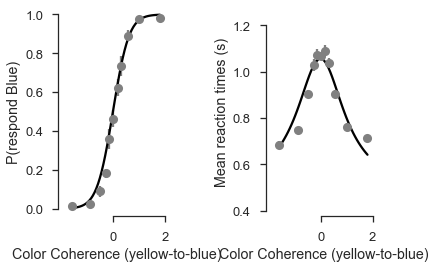

In [13]:
datadotsplothc=np.column_stack([dotshc['color_coh'],dotshc['RT'],dotshc['choseblue'],dotshc['subjid']])
thetadotshc=pickle.load(open("thetadotsHC.p", "rb"))
# Plot dots data with fits
plotDotsDataWithFit(datadotsplothc, thetadotshc.x, dt=.0005)

## Fit DDM to Dots AN

In [24]:
thetadotsan=fitData(datadotsan)
pickle.dump(thetadotsan, open("thetadotsAN.p", "wb"))

Optimization terminated successfully.
         Current function value: 23717.498984
         Iterations: 423
         Function evaluations: 687


## Plot Dots AN with fit

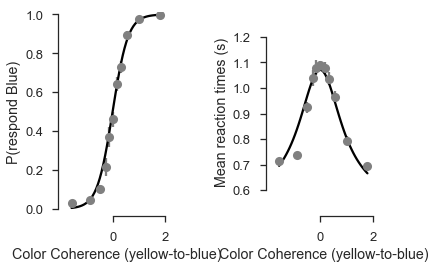

In [14]:
datadotsplotan=np.column_stack([dotsan['color_coh'],dotsan['RT'],dotsan['choseblue'],dotsan['subjid']])
thetadotsan=pickle.load(open("thetadotsAN.p", "rb"))
# Plot dots data with fits
plotDotsDataWithFit(datadotsplotan, thetadotsan.x, dt=.0005)

## Load in Food data

In [15]:
foodhc=pd.read_csv('HCfood.csv',header=0)
foodhc=foodhc[foodhc.Response!='x']
foodhc=foodhc[foodhc.RT > .3]
foodhc['deltavalrnd']=foodhc['deltavalz'].round(1)
datafoodhc=np.column_stack([foodhc['deltavalrnd'],foodhc['RT'],foodhc['choseright'].astype('bool')])

foodan=pd.read_csv('ANfood.csv',header=0)
foodan=foodan[foodan.Response!='x']
foodan=foodan[foodan.RT > .3]
foodan['deltavalrnd']=foodan['deltavalz'].round(1)
datafoodan=np.column_stack([foodan['deltavalrnd'],foodan['RT'],foodan['choseright'].astype('bool')])

## Fit DDM to Food HC 

In [66]:
thetafoodhc=fitData(datafoodhc)
pickle.dump(thetafoodhc, open("thetafoodHC.p", "wb"))

Optimization terminated successfully.
         Current function value: 26562.346715
         Iterations: 778
         Function evaluations: 1201


## Plot Food HC with fit

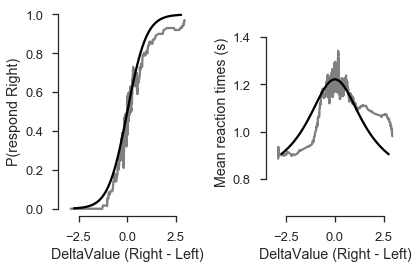

In [16]:
datafoodplothc=np.column_stack([foodhc['deltavalrnd'],foodhc['RT'],foodhc['choseright'],foodhc['subjectID'],foodhc['deltavalz']])
thetafoodhc=pickle.load(open("thetafoodHC.p", "rb"))
# Plot dots data with fits
plotFoodDataWithFit(datafoodplothc, thetafoodhc.x, dt=.0005)

## Fit DDM to Food AN

In [68]:
thetafoodan=fitData(datafoodan)
pickle.dump(thetafoodan, open("thetafoodAN.p", "wb"))

Optimization terminated successfully.
         Current function value: 26403.784498
         Iterations: 682
         Function evaluations: 1050


## Plot Food AN with fit

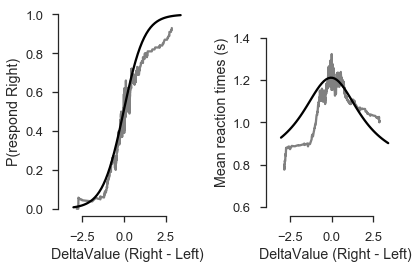

In [17]:
datafoodplotan=np.column_stack([foodan['deltavalrnd'],foodan['RT'],foodan['choseright'],foodan['subjectID'],foodan['deltavalz']])
thetafoodan=pickle.load(open("thetafoodAN.p", "rb"))
# Plot dots data with fits
plotFoodDataWithFit(datafoodplotan, thetafoodan.x, dt=.0005)

In [ ]:
%%R -i dots
## there is no good package to run mixed effects logistic regression, using R's lme4 package
chosebluemod=glmer(choseblue ~  group * color_coh + (1|subjid), family='binomial', data=dots)
print(summary(chosebluemod))
sjp.setTheme(base = theme_classic())
sjp.int(chosebluemod,type = "eff",show.ci=T)#,show.values=T)

dots$abscolorcoh=abs(dots$color_coh)
## compare the model using python's statsmodels (above) to R's lme4
dotsrtmod=lmer(RT ~ group * abscolorcoh + (1|subjid), data=dots)
print(summary(dotsrtmod))
sjp.int(dotsrtmod,type='eff',show.ci=T, vars="abscolorcoh")

In [ ]:
foodhc=foodhc.assign(group='HC')
foodan=foodan.assign(group='AN')
food=foodhc.append(foodan)

In [ ]:
%%R -i food
## there is no good package to run mixed effects logistic regression, using R's lme4 package
choserightmod=glmer(choseright ~  group * deltavalz + (1|subjectID), family='binomial', data=food)
print(summary(choserightmod))
sjp.setTheme(base = theme_classic())
sjp.int(choserightmod,type = "eff",show.ci=T)

food$absdeltaval=abs(food$deltavalz)
## compare the model using python's statsmodels (above) to R's lme4
foodrtmod=lmer(log(RT) ~ group * absdeltaval + (1|subjectID), data=food)
print(summary(foodrtmod))
sjp.int(foodrtmod,type='eff',show.ci=T, vars="absdeltaval")